In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from sklearn.metrics import confusion_matrix , classification_report
from keras.utils import to_categorical
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

2024-04-25 06:54:27.645842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 06:54:27.645896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 06:54:27.647363: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [3]:
y = data['label']
x = data.drop(columns = ['label'])
x.shape

(10015, 2352)

In [4]:
other = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
other.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
classes = {4: ('nv', ' melanocytic nevi'), 
           6: ('mel', 'melanoma'), 
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'), 
           5: ('vasc', ' pyogenic granulomas and hemorrhage'), 
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  
           3: ('df', 'dermatofibroma')}

Text(0.5, 1.0, 'Frequency Distribution of Classes')

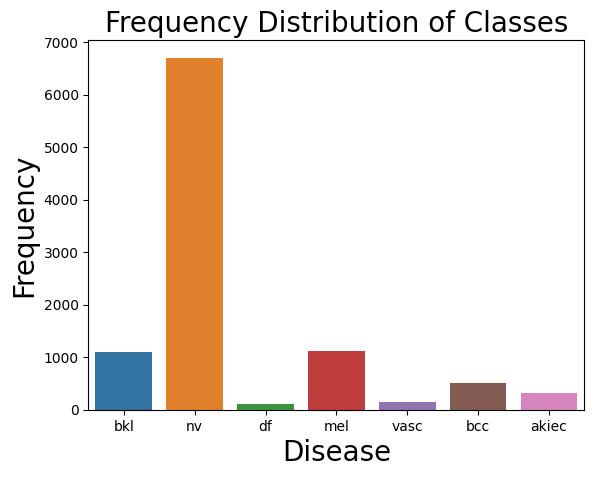

In [6]:
sns.countplot(x = 'dx', data = other)
plt.xlabel('Disease', size=20)
plt.ylabel('Frequency', size=20)
plt.title('Frequency Distribution of Classes', size=20)

In [7]:
k = y.map(classes.get) 
k.value_counts() < 1000, k.value_counts() > 5000,k.value_counts()

(label
 (nv,  melanocytic nevi)                                      False
 (mel, melanoma)                                              False
 (bkl, benign keratosis-like lesions)                         False
 (bcc,  basal cell carcinoma)                                  True
 (akiec, Actinic keratoses and intraepithelial carcinomae)     True
 (vasc,  pyogenic granulomas and hemorrhage)                   True
 (df, dermatofibroma)                                          True
 Name: count, dtype: bool,
 label
 (nv,  melanocytic nevi)                                       True
 (mel, melanoma)                                              False
 (bkl, benign keratosis-like lesions)                         False
 (bcc,  basal cell carcinoma)                                 False
 (akiec, Actinic keratoses and intraepithelial carcinomae)    False
 (vasc,  pyogenic granulomas and hemorrhage)                  False
 (df, dermatofibroma)                                         False
 Name: 

Text(0.5, 1.0, 'Gender of Patient')

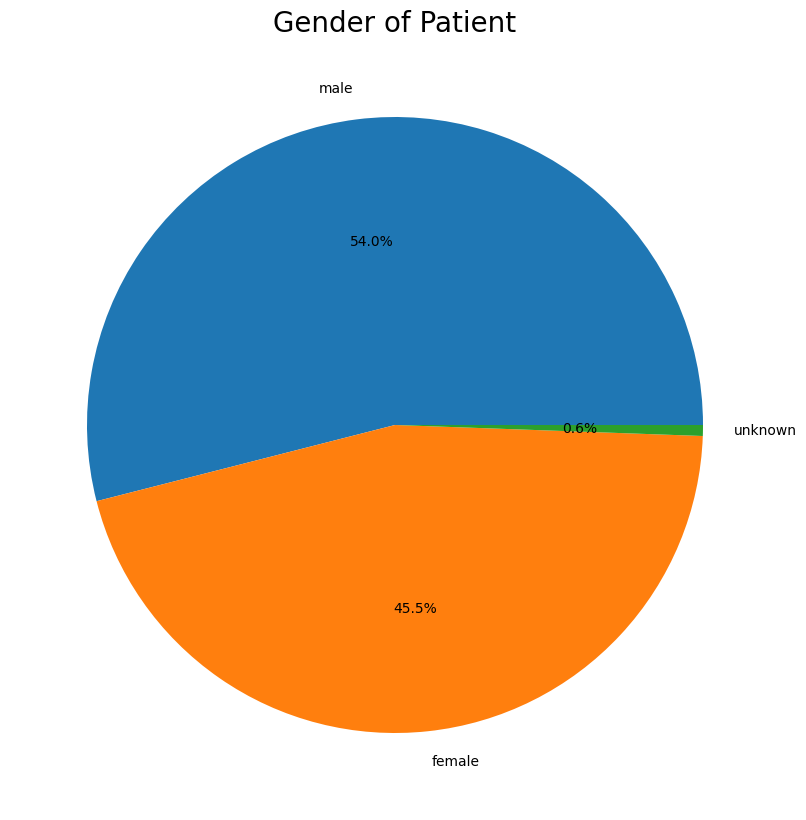

In [8]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(other['sex'].value_counts(), 
        labels = other['sex'].value_counts().index, 
        autopct="%.1f%%")
plt.title('Gender of Patient', size=20)

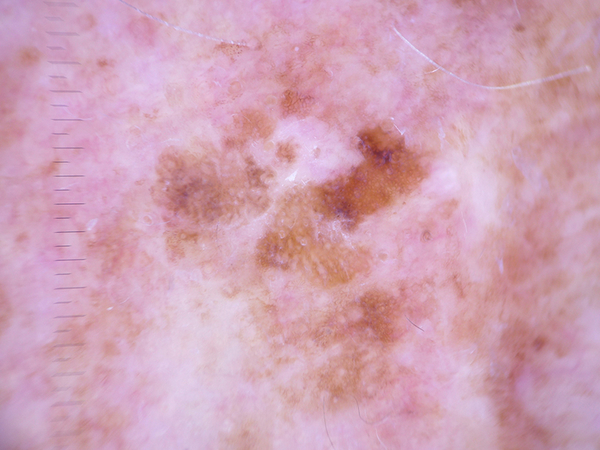

In [9]:
Image.open('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027419.jpg')

Text(0.5, 1.0, 'Histogram of Age of Patients')

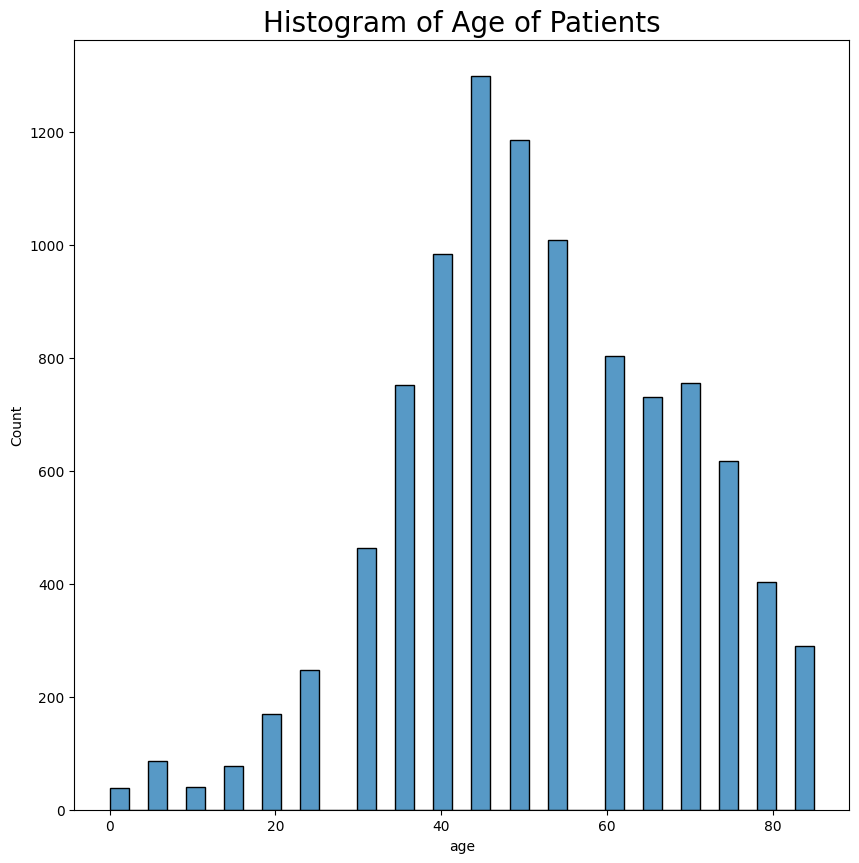

In [10]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(other['age'])
plt.title('Histogram of Age of Patients', size=20)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

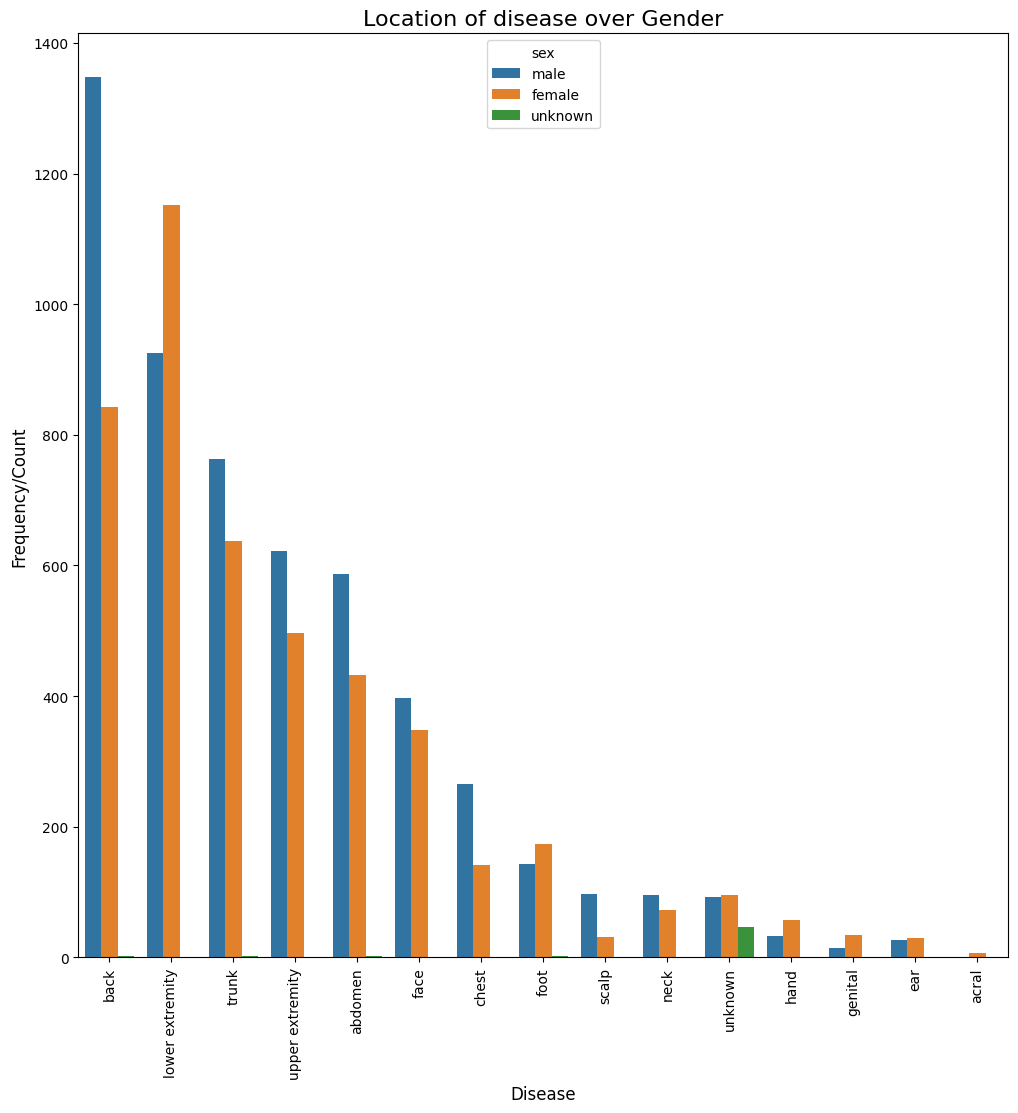

In [11]:
value = other[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

In [12]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)
x = np.array(x).reshape(-1,28,28,3)
print('Shape of Data :',x.shape)

Shape of Data : (46935, 28, 28, 3)


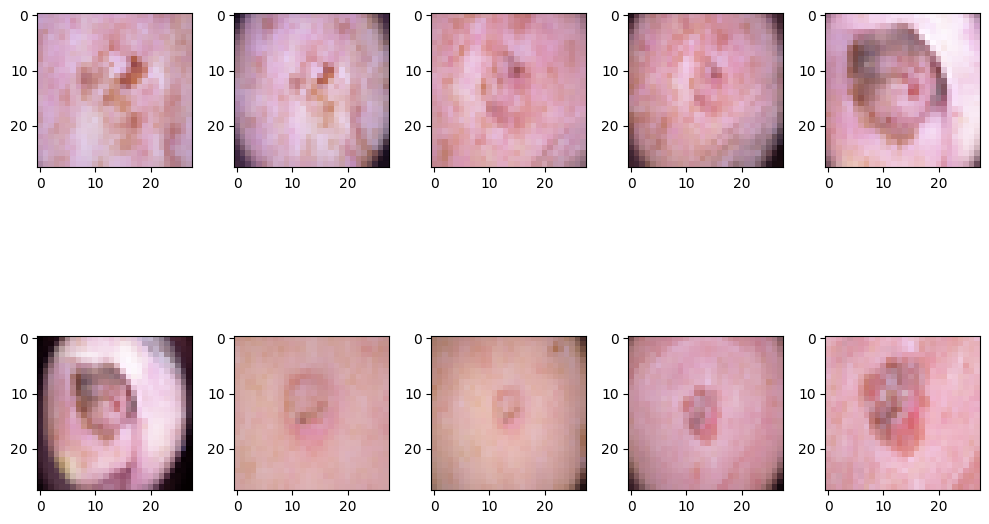

In [13]:
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0 
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x[k].reshape(28,28,3))
        k = k + 1
    plt.tight_layout()

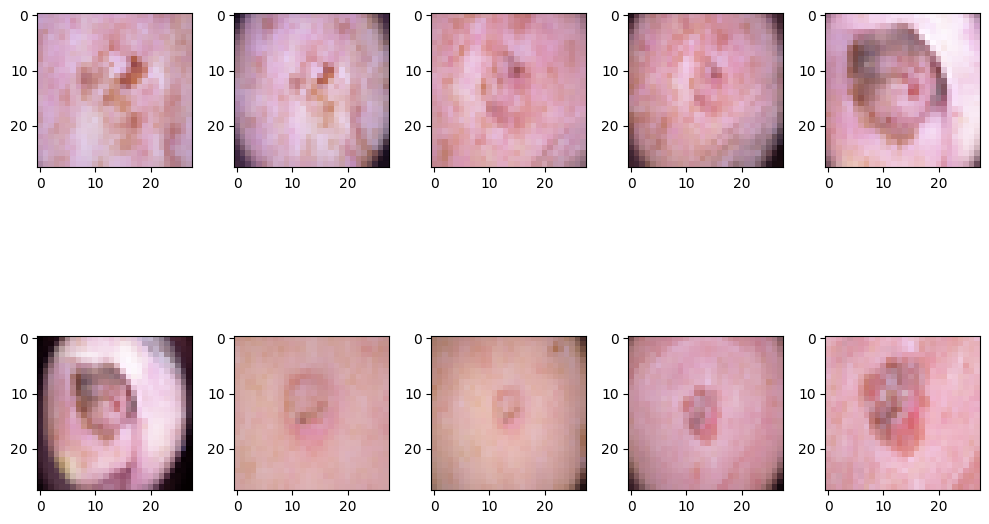

In [14]:
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0 
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x[k].reshape(28,28,3))
        k = k + 1
    plt.tight_layout()

In [15]:
x = (x-np.mean(x))/np.std(x)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=42)

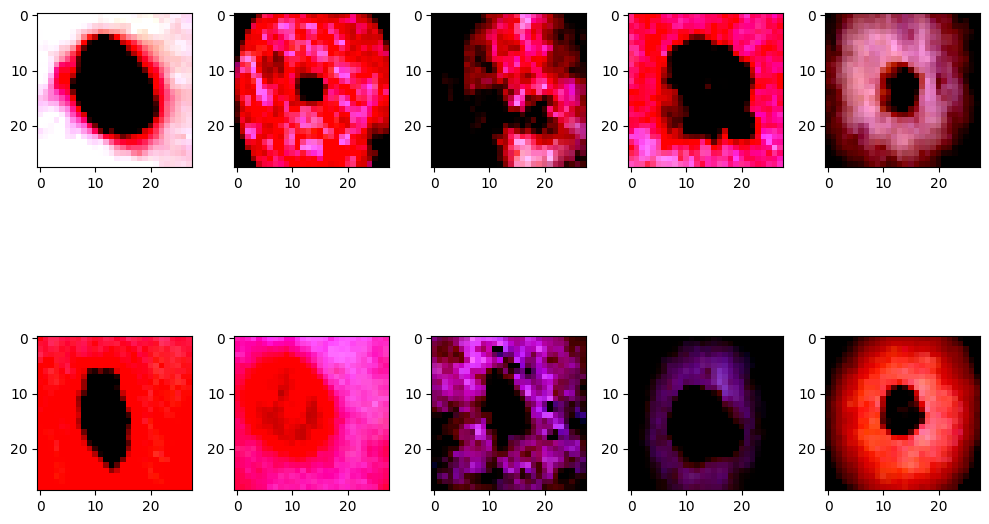

In [17]:
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0 
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(X_train[k].reshape(28,28,3))
        k = k + 1
    plt.tight_layout()

In [18]:
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,663 (713.53 KB)

 Trainable params: 182,663 (713.53 KB)

 Non-trainable params: 0 (0.00 B)

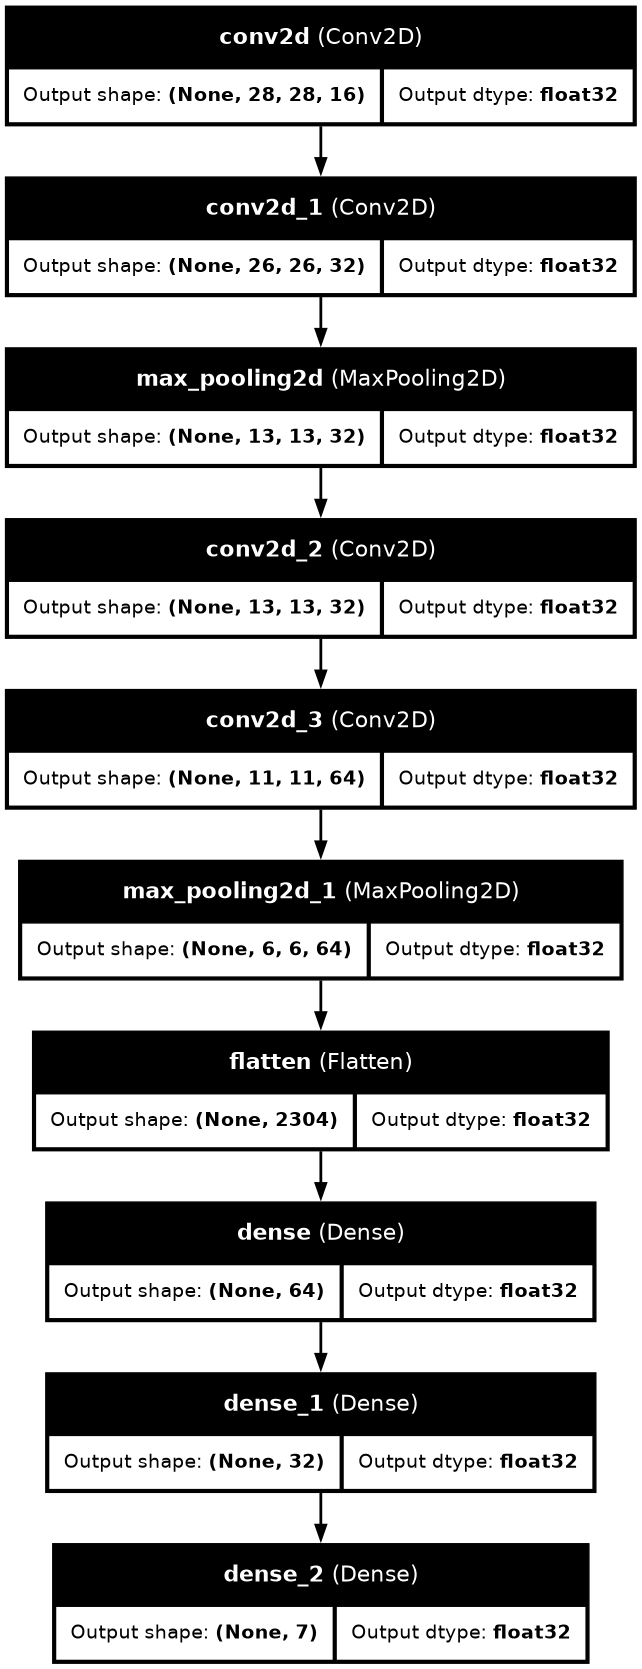

In [19]:
tf.keras.utils.plot_model(model, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB", expand_nested = True, dpi = 100)

In [20]:
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5.keras',
                                                  monitor='val_accuracy',
                                                 verbose=0)
File = 'SkinDiseases'
callback = [Checkpoint,
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format(File))]

In [21]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 50,
                    callbacks=[callback])

Epoch 1/50


2024-04-25 06:54:49.449580: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.28693, expected 2.63109
2024-04-25 06:54:49.449630: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.37105, expected 2.71521
2024-04-25 06:54:49.449644: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.69062, expected 3.03478
2024-04-25 06:54:49.449657: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.53917, expected 2.88333
2024-04-25 06:54:49.449670: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.81121, expected 3.15537
2024-04-25 06:54:49.449679: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.71916, expected 2.06332
2024-04-25 06:54:49.449689: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.69741, expected 3.04157
2024-04-25 06:54:49.449699: E external/local_xla/xla/se

 20/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1775 - loss: 1.8964

I0000 00:00:1714028091.647728    4071 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714028091.661714    4071 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


224/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3649 - loss: 1.5611

2024-04-25 06:54:53.135817: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.47348, expected 3.62048
2024-04-25 06:54:53.135876: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.42029, expected 3.5673
2024-04-25 06:54:53.135886: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.82036, expected 2.96736
2024-04-25 06:54:53.135894: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.19279, expected 3.33979
2024-04-25 06:54:53.135901: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.53777, expected 3.68477
2024-04-25 06:54:53.135918: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.92035, expected 4.06735
2024-04-25 06:54:53.135926: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.96136, expected 4.10837
2024-04-25 06:54:53.135933: E external/local_xla/xla/ser

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3711 - loss: 1.5481

W0000 00:00:1714028095.917475    4071 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.3716 - loss: 1.5470 - val_accuracy: 0.6723 - val_loss: 0.8941
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7238 - loss: 0.7543 - val_accuracy: 0.7221 - val_loss: 0.7965
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7937 - loss: 0.5660 - val_accuracy: 0.7021 - val_loss: 1.0795
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7706 - loss: 0.6917 - val_accuracy: 0.7248 - val_loss: 0.7338
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8722 - loss: 0.3643 - val_accuracy: 0.7971 - val_loss: 0.6673
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8569 - loss: 0.4191 - val_accuracy: 0.8722 - val_loss: 0.3454
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8967 - loss: 0.2791 - val_accuracy: 0.8975 - val_loss: 0.3176
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9375 - loss: 0.1793 - val_accuracy: 0.8911 - val

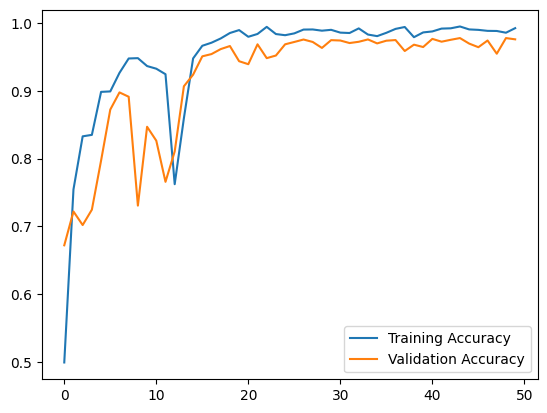

In [22]:
plt.plot(history.history["accuracy"] , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] ,label = "Validation Accuracy")
plt.legend()
plt.show()

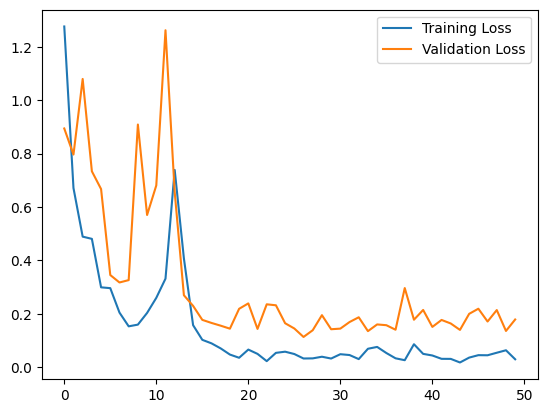

In [23]:
plt.plot(history.history["loss"] ,  label = "Training Loss")
plt.plot(history.history["val_loss"] , label = "Validation Loss")
plt.legend()
plt.show()

In [24]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [25]:
Y_pred  = model.predict(X_test).round()

2024-04-25 06:56:05.077119: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.13766, expected 3.32655
2024-04-25 06:56:05.077179: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.34, expected 4.52888
2024-04-25 06:56:05.077192: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.1601, expected 3.34898
2024-04-25 06:56:05.077205: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.16167, expected 4.35055
2024-04-25 06:56:05.077217: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.26013, expected 4.44902
2024-04-25 06:56:05.077227: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.10789, expected 4.29677
2024-04-25 06:56:05.077238: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.789, expected 3.97789
2024-04-25 06:56:05.077248: E external/local_xla/xla/service/

281/294 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2024-04-25 06:56:06.204729: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 784: 3.89067, expected 3.151
2024-04-25 06:56:06.204773: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786: 4.87851, expected 4.13884
2024-04-25 06:56:06.204782: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 787: 5.08924, expected 4.34956
2024-04-25 06:56:06.204790: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 788: 5.69716, expected 4.95749
2024-04-25 06:56:06.204798: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 789: 5.7147, expected 4.97503
2024-04-25 06:56:06.204805: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 790: 4.89133, expected 4.15166
2024-04-25 06:56:06.204813: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 791: 5.60215, expected 4.86248
2024-04-25 06:56:06.204820: E external/local

294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [26]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(Y_test, Y_pred)

print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9711302865665282


In [27]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(Y_test , Y_pred , target_names =target_names ))

                                                               precision    recall  f1-score   support

('akiec', 'Actinic keratoses and intraepithelial carcinomae')       0.99      1.00      0.99      1295
                             ('bcc', ' basal cell carcinoma')       0.98      1.00      0.99      1323
                     ('bkl', 'benign keratosis-like lesions')       0.92      0.99      0.95      1351
                                     ('df', 'dermatofibroma')       1.00      1.00      1.00      1392
                                  ('nv', ' melanocytic nevi')       0.99      0.84      0.91      1346
              ('vasc', ' pyogenic granulomas and hemorrhage')       1.00      1.00      1.00      1292
                                          ('mel', 'melanoma')       0.95      0.97      0.96      1388

                                                    micro avg       0.97      0.97      0.97      9387
                                                    macro avg       0.9

<Axes: >

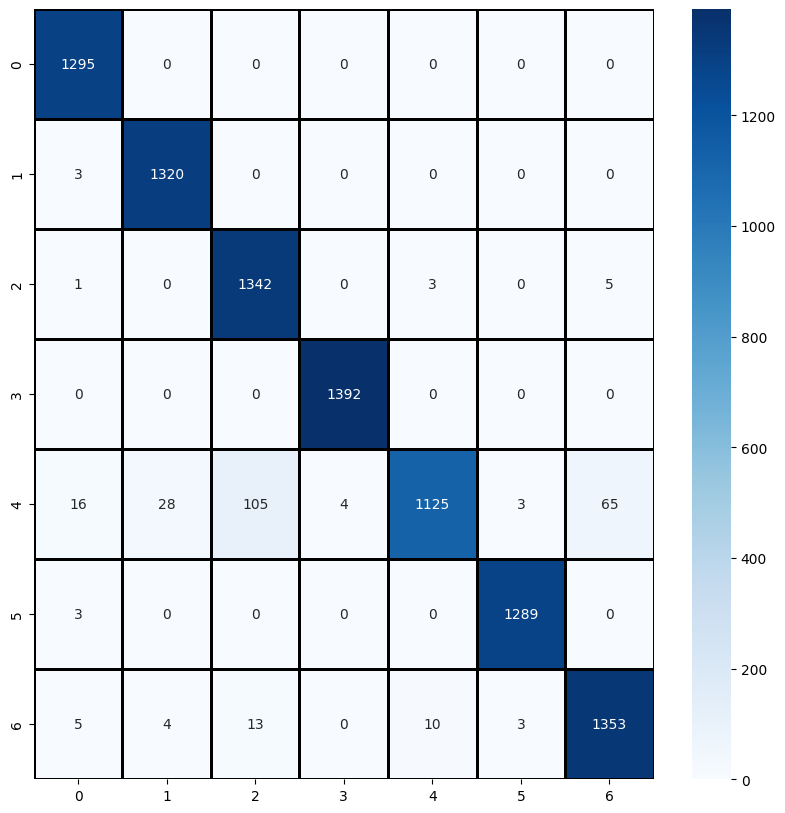

In [28]:
cm = confusion_matrix(Y_test.argmax(axis = 1) , Y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = [i for i in range(7)] , columns = [i for i in range(7)])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

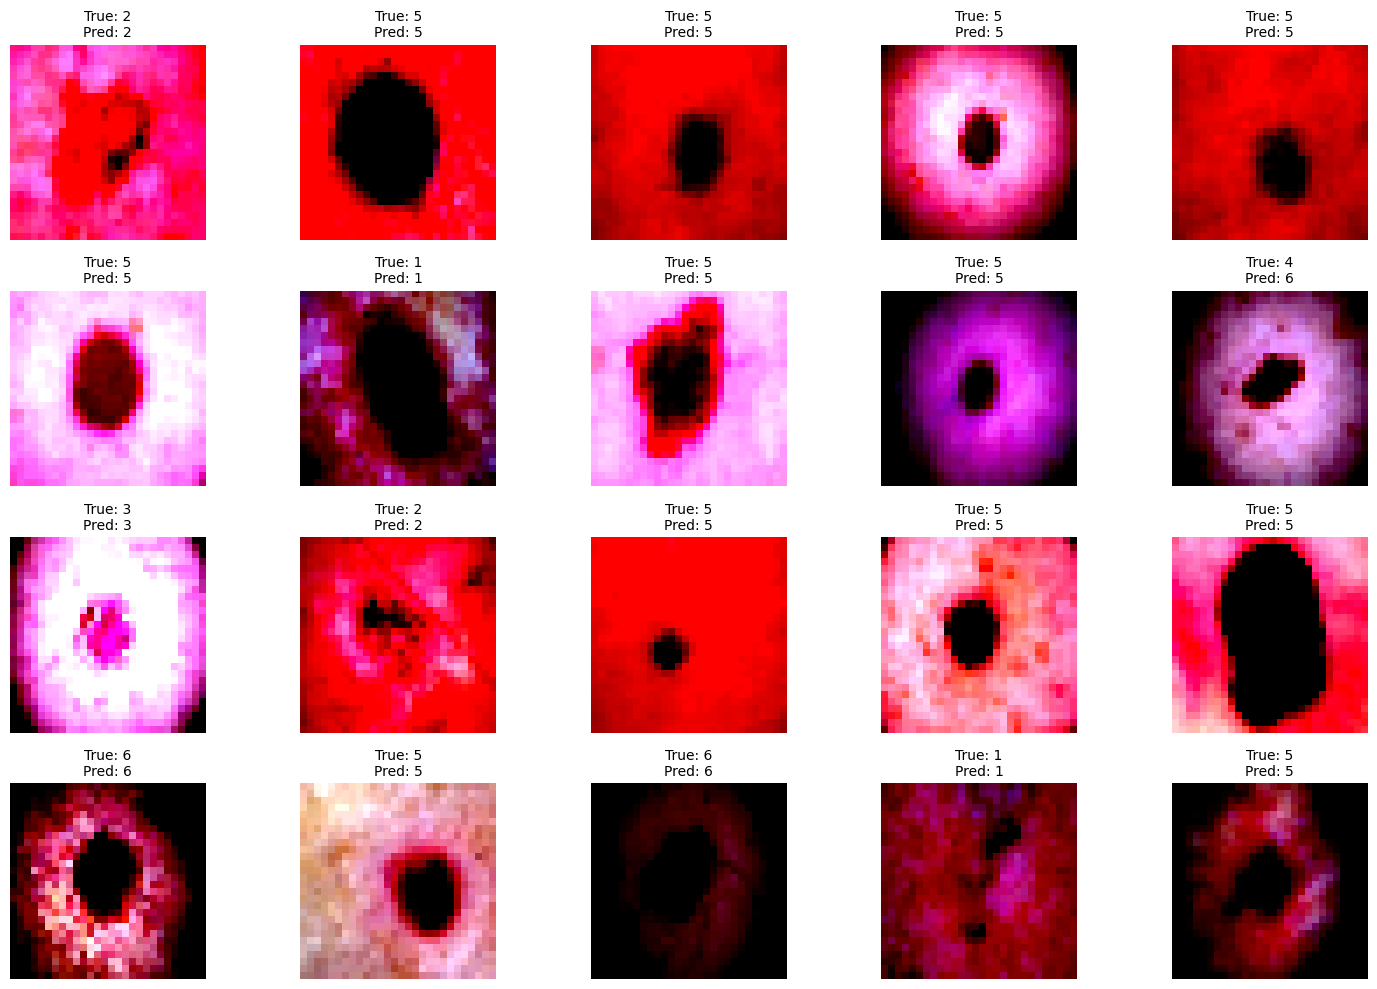

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def display_images(images, labels_true, labels_pred, class_names, num_rows=4, num_cols=5, figsize=(15, 10)):
    plt.figure(figsize=figsize)
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels_true[i]]}\nPred: {class_names[labels_pred[i]]}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()  
    plt.show()

if len(Y_test.shape) > 1:
    Y_test = np.argmax(Y_test, axis=1)
if len(Y_pred.shape) > 1:
    Y_pred = np.argmax(Y_pred, axis=1)


display_images(X_test, Y_test, Y_pred, class_names=["0", "1", "2", "3", "4", "5", "6"], num_rows=4, num_cols=5, figsize=(15, 10))
